<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/FastAI_2022_Random_Forests_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reviewing the Inner Workings of Random Forests**

## Setup

In [1]:
!pip install kaggle

In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [4]:
# Kaggle
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
# Credentials storage
# Using Kaggle API key
creds = '{"username":"bachaudhry","key":"f8e0ee26f34cb0d3e4eccd774de62f63"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [5]:
if iskaggle:
  path = Path('../input/titanic')
else:
  import zipfile, kaggle
  path = Path('titanic')
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 14.8MB/s]

## Data Pre-processing

In [6]:
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

One interesting point that popped up during the lessons was that Jeremy suggested that we don't need to create dummy variables when working with Random Forests.

Instead, his suggestion was to convert those fields to categoricals instead. Obviously, I'll need to test this on different datasets.

Also, does this carry over to boosted models as well?

In [7]:
# This is a pretty hacky pre-processing function
def proc_data (df):
  df['Fare'] = df.Fare.fillna(0)
  df.fillna(modes, inplace=True)
  df['LogFare'] = np.log1p(df['Fare'])
  df['Embarked'] = pd.Categorical(df.Embarked)
  df['Sex'] = pd.Categorical(df.Sex)

# Processing train and test sets
proc_data(df)
proc_data(tst_df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    category
 12  LogFare      891 non-null    float64 
dtypes: category(2), float64(3), int64(5), object(3)
memory usage: 78.7+ KB


In [9]:
tst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Name         418 non-null    object  
 3   Sex          418 non-null    category
 4   Age          418 non-null    float64 
 5   SibSp        418 non-null    int64   
 6   Parch        418 non-null    int64   
 7   Ticket       418 non-null    object  
 8   Fare         418 non-null    float64 
 9   Cabin        418 non-null    object  
 10  Embarked     418 non-null    category
 11  LogFare      418 non-null    float64 
dtypes: category(2), float64(3), int64(4), object(3)
memory usage: 33.8+ KB


In [10]:
# Creating lists of continuous, categorical and dependent variables
# Pclass will no longer be used a variable since it is ordered.
cats = ["Sex", "Embarked"]
conts = ["Age", "SibSp", "Parch", "LogFare", "Pclass"]
dep = "Survived"

In [11]:
# Checking if the categorical codes exist or not.
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

## Binary Splits

This is a quick demonstration of creating Binary Splits, which are used to create Decision Trees.

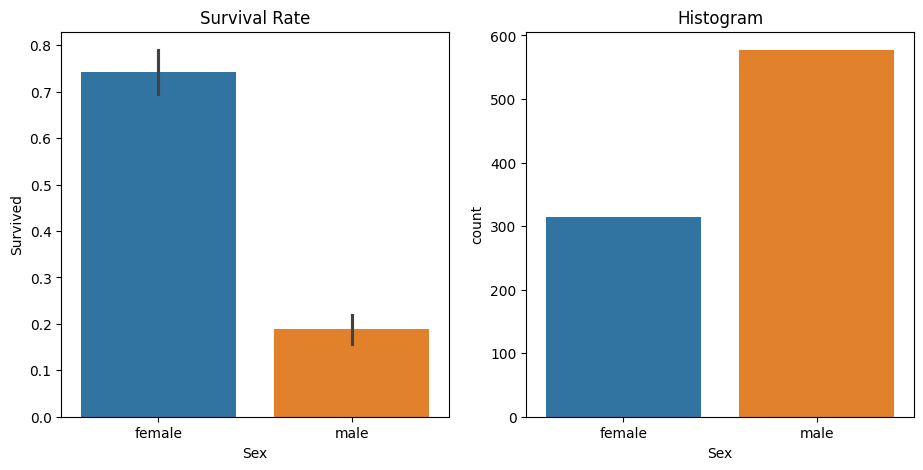

In [12]:
# Taking the example of the independent variable "Sex"
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axes[0], hue="Sex").set(title="Survival Rate")
sns.countplot(data=df, x="Sex", ax=axes[1], hue="Sex").set(title="Histogram");

The groups above have very different survival rates between males and females.

We can create a somewhat even split with each group comprising 300 passengers.

In [13]:
random.seed(42) # For reproducibility purposes
trn_df, val_df = train_test_split(df, test_size=0.25)

trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [14]:
# Creating independent and dependent variables
def xs_y(df):
  xs = df[cats + conts].copy()
  return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

In [15]:
# Predictions for the single variable model.
preds = val_xs.Sex==0

In [16]:
# Using mean-absolute-error as our performance metric
mean_absolute_error(val_y, preds)

0.25112107623318386

Splitting on a continuous column...

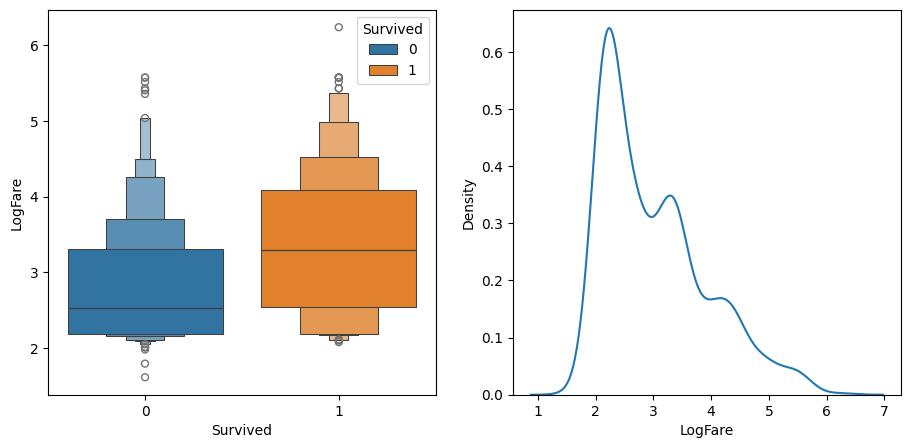

In [17]:
# Looking at LogFare for this test
df_fare = trn_df[trn_df.LogFare > 0]

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axes[0], hue="Survived")
sns.kdeplot(data=df_fare, x="LogFare", ax=axes[1]);

In [18]:
# The median LogFare for survivors is around 3.2 and for those that didn't
# it is around 2.5.
preds = val_xs.LogFare > 2.7
# Checking performance
mean_absolute_error(val_y, preds)

0.34977578475336324

This is less accurate than `Sex`.

In a universe where Random Forests didn't exist, we would need to create functions to show our model's performance across a wide variety of variables and their resulting splits.

To do this, we would need to create a score function to measure impurity i.e. measures the similarity / dissimilarity between rows of groups being used in the binary split.

In [19]:
# Similarity of rows can be measured using Std. Deviation.
def _side_score(side, y):
  tot = side.sum()
  if tot <= 1:
    return 0
  return y[side].std() * tot

# Calculating the score for a split by adding up the scores for the left and
# right hand sides.
def score(col, y, split):
  lhs = col <= split
  return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)

In [20]:
# Checking the impurity score the split using Sex
score(trn_xs["Sex"], trn_y, 0.5)

0.3991589162052909

In [21]:
# Doing the same for LogFare
score(trn_xs["LogFare"], trn_y, 2.7)

0.46925167449716854

We could also experiment with binary splits by using widgets...

In [22]:
def iscore(nm, split):
  col = trn_xs[nm]
  return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [23]:
# A semi automated way of finding splits would be to pick the lowest impurity scores
# from a list
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 25.  , 26.  , 27.  , 28.  ,
       28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ])

In [24]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()], unq[scores.argmax()]

(0.92, 71.0)

In [25]:
# Using the idea that 6 is the optimum cut-off
def min_col(df, nm):
  col, y = df[nm], df[dep]
  unq = col.dropna().unique()
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
  idx = scores.argmin()
  return unq[idx], scores[idx]

min_col(trn_df, "Age")

(0.92, 0.47885372723555797)

In [26]:
# Applying this to all columns
cols = cats + conts
{o: min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.3991589162052909),
 'Embarked': (1, 0.47881541767461183),
 'Age': (0.92, 0.47885372723555797),
 'SibSp': (3, 0.4770847068888606),
 'Parch': (0, 0.4811915917763749),
 'LogFare': (2.4390808375825834, 0.4644438802501407),
 'Pclass': (2, 0.4580671854511058)}

We basically implemented the [OneR](https://https://link.springer.com/article/10.1023/A:1022631118932) classifier in the section above. In theory, this could be a good baseline for small datasets.

## Creating a Decision Tree

Building on the previous section, we will create additional binary splits to demonstrate the basic concept behind decision trees.

In [27]:
# Removing Sex from the list of possible splits since there is only one possible split
# for binary columns
cols.remove("Sex")

ismale = trn_df.Sex == 1
isfemale = trn_df.Sex != 1 # For some reason, ~males wasn't working
males, females = trn_df[ismale], trn_df[isfemale]

In [28]:
females

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
58,59,1,2,"West, Miss. Constance Mirium",0,5.0,1,2,C.A. 34651,27.7500,B96 B98,2,3.358638
24,25,0,3,"Palsson, Miss. Torborg Danira",0,8.0,3,1,349909,21.0750,B96 B98,2,3.094446
780,781,1,3,"Ayoub, Miss. Banoura",0,13.0,0,0,2687,7.2292,B96 B98,0,2.107689
356,357,1,1,"Bowerman, Miss. Elsie Edith",0,22.0,0,1,113505,55.0000,E33,2,4.025352
123,124,1,2,"Webber, Miss. Susan",0,32.5,0,0,27267,13.0000,E101,2,2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",0,26.0,0,0,19877,78.8500,B96 B98,2,4.380150
596,597,1,2,"Leitch, Miss. Jessie Wills",0,24.0,0,0,248727,33.0000,B96 B98,2,3.526361
591,592,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",0,52.0,1,0,36947,78.2667,D20,0,4.372818
19,20,1,3,"Masselmani, Mrs. Fatima",0,24.0,0,0,2649,7.2250,B96 B98,0,2.107178


In [29]:
# Finding the best binary split for males
{o: min_col(males, o) for o in cols}

{'Embarked': (0, 0.37949535334135626),
 'Age': (9.0, 0.36675971552146547),
 'SibSp': (4, 0.3784204005664346),
 'Parch': (0, 0.37912718856363564),
 'LogFare': (3.2930552230424524, 0.36968332117646197),
 'Pclass': (1, 0.36839610518021165)}

In [30]:
# Now for females
{o: min_col(females, o) for o in cols}

{'Embarked': (1, 0.4233439583276359),
 'Age': (50.0, 0.41688322350997375),
 'SibSp': (3, 0.40296373161706267),
 'Parch': (1, 0.41946227258632646),
 'LogFare': (3.8691155044168695, 0.40017460396816124),
 'Pclass': (2, 0.34353629820603615)}

Now that we have some reasonable binary splits for males and females, we could
spend a considerable amount of time coding in additional rules for columns such as `Age` or `Pclass`. The process would then be repeated.

Or....we could just use the `sklearn` library to handle all of that for us.

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [46]:
# Visualizing our newly created tree
import graphviz

def draw_tree(t, df, size=10, ratio=1.05, precision=2, **kwargs):
  s = export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      rounded=True, special_characters=True, rotate=False,
                      precision=precision, **kwargs)
  return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

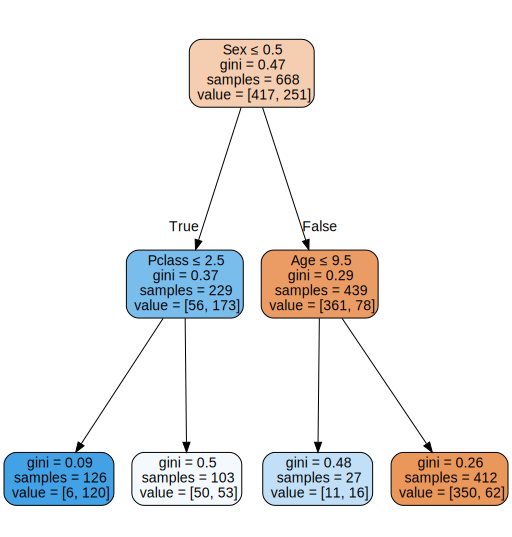

In [47]:
draw_tree(model, trn_xs, size=10)

Here the measure of impurity is `gini` which is not to be confused with the Gini-Coefficient which is used in economics.

In [48]:
def gini(cond):
  act = df.loc[cond, dep]
  return 1 - act.mean()**2 - (1-act).mean()**2

In [49]:
# Gini calculates the probability of getting the same target variable, each time,
# if we pick two rows from a group.
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [50]:
# Comparing the OneR version
mean_absolute_error(val_y, model.predict(val_xs))

0.24663677130044842

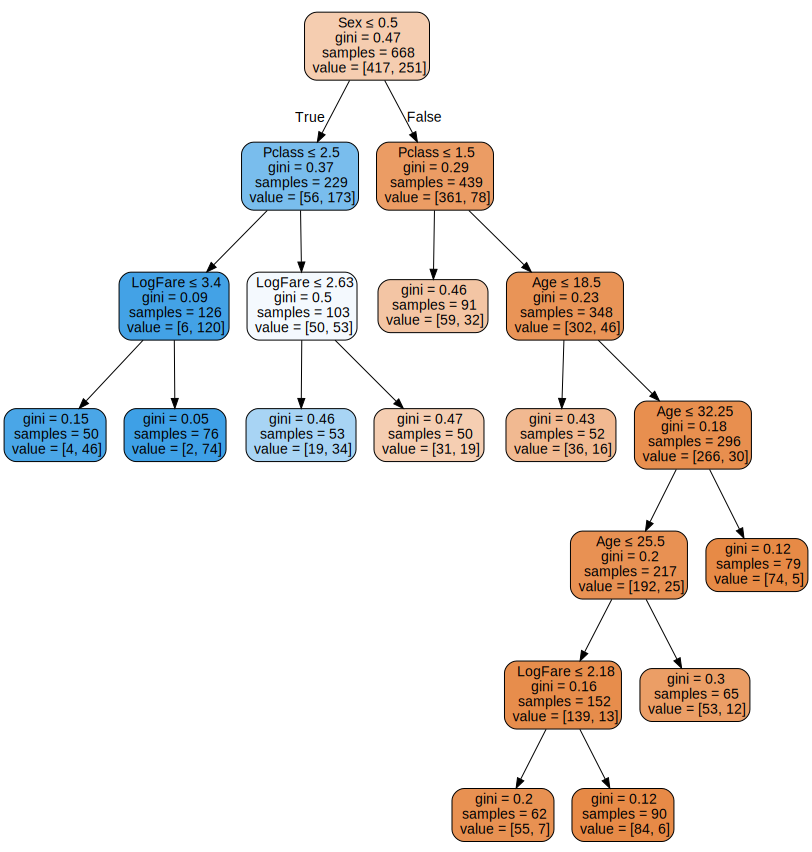

In [53]:
# Building a bigger tree
model = DecisionTreeClassifier(min_samples_leaf=50)
model.fit(trn_xs, trn_y)
draw_tree(model, trn_xs, size=14)

In [55]:
mean_absolute_error(val_y, model.predict(val_xs))

0.23318385650224216

## Moving onto Random Forrests